# **Import Required Libraries and Modules**

In [ ]:
## import certain packages
import math
import numpy as np
import seaborn as sns
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import datetime, date
from math import log, sqrt, pi, exp
from scipy.stats import norm

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# **Binomial Tree Model**

In [ ]:
import math

def binomial_tree_option_pricing(
    initial_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    volatility,
    number_of_steps,
    option_type
):
    delta_t = time_to_maturity / number_of_steps
    up_factor = math.exp(volatility * math.sqrt(delta_t))
    down_factor = 1 / up_factor
    risk_neutral_up_prob = (math.exp(risk_free_rate * delta_t) - down_factor) / (up_factor - down_factor)
    risk_neutral_down_prob = 1 - risk_neutral_up_prob
    discount_factor = math.exp(-risk_free_rate * delta_t)

    final_stock_prices = [
        initial_stock_price * (up_factor ** j) * (down_factor ** (number_of_steps - j))
        for j in range(number_of_steps + 1)
    ]

    option_type = option_type.upper()
    if option_type == 'C':
        option_values = [max(price - strike_price, 0) for price in final_stock_prices]
    elif option_type == 'P':
        option_values = [max(strike_price - price, 0) for price in final_stock_prices]
    else:
        raise ValueError("option_type must be 'C' (call) or 'P' (put)")

    for step in range(number_of_steps - 1, -1, -1):
        for i in range(step + 1):
            option_values[i] = discount_factor * (
                risk_neutral_up_prob * option_values[i + 1] +
                risk_neutral_down_prob * option_values[i]
            )

    return option_values[0]


Testing the Binomial Tree Model with Sample Inputs

In [ ]:
# Sample input values
initial_stock_price = 100       # Current stock price (S₀)
strike_price = 110              # Strike price (K)
time_to_maturity = 0.1          # Time to maturity in years (T)
risk_free_rate = 0.1            # Annual risk-free interest rate (r)
volatility = 10                 # Annual volatility (σ)
number_of_steps = 3             # Number of steps in the binomial tree (N)
option_type = 'C'               # 'C' for Call option

# Call the pricing function for call type
price = binomial_tree_option_pricing(
    initial_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    volatility,
    number_of_steps,
    option_type
)

print(f"European Call Option Price (Binomial Tree, {number_of_steps} steps): {price:.4f}")


European Call Option Price (Binomial Tree, 3 steps): 89.0475


In [ ]:
# Sample input values
initial_stock_price = 100       # Current stock price (S₀)
strike_price = 90               # Strike price (K)
time_to_maturity = 0.1          # Time to maturity in years (T)
risk_free_rate = 0.1            # Annual risk-free interest rate (r)
volatility = 10                 # Annual volatility (σ)
number_of_steps = 5             # Number of steps in the binomial tree (N)
option_type = 'P'               # 'P' for put option

# Call the pricing function for put type
price = binomial_tree_option_pricing(
    initial_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    volatility,
    number_of_steps,
    option_type
)

print(f"European Put Option Price (Binomial Tree, {number_of_steps} steps): {price:.4f}")


European Put Option Price (Binomial Tree, 5 steps): 78.7882


# **Black-Scholes model**

In [ ]:
# Compute the d1 term used in the Black-Scholes formula
def compute_d1(
    current_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    volatility
):
    # Numerator includes the log of the stock/strike ratio plus an adjustment for risk-free rate and volatility
    numerator = np.log(current_stock_price / strike_price) + \
                (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity

    # Denominator is the volatility scaled by the square root of time
    denominator = volatility * np.sqrt(time_to_maturity)

    # Return the d1 value
    return numerator / denominator

# Compute the d2 term used in the Black-Scholes formula
def compute_d2(
    current_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    volatility
):
    # d2 is derived from d1 by subtracting volatility * sqrt(time)
    return compute_d1(
        current_stock_price,
        strike_price,
        time_to_maturity,
        risk_free_rate,
        volatility
    ) - volatility * np.sqrt(time_to_maturity)

# Calculate the Black-Scholes price for a European call or put option
def black_scholes_price(
    current_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    volatility,
    option_type='call'
):
    # Calculate d1 and d2 for use in the Black-Scholes formula
    d1 = compute_d1(current_stock_price, strike_price, time_to_maturity, risk_free_rate, volatility)
    d2 = d1 - volatility * np.sqrt(time_to_maturity)

    # Compute price based on option type
    if option_type.lower() == 'call':
        # Call option price formula
        return current_stock_price * norm.cdf(d1) - \
               strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        # Put option price formula
        return strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(-d2) - \
               current_stock_price * norm.cdf(-d1)
    else:
        # Raise error if the option type is not recognized
        raise ValueError("option_type must be 'call' or 'put'")


In [ ]:
# Function to calculate Black-Scholes option Greeks for European call/put
def black_scholes_greeks(
    current_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    volatility,
    option_type='call'
):
    # Calculate d1 and d2 for the Black-Scholes model
    d1 = compute_d1(current_stock_price, strike_price, time_to_maturity, risk_free_rate, volatility)
    d2 = d1 - volatility * np.sqrt(time_to_maturity)

    # N(d1) and N(d2), adjusted for call or put
    Nd1 = norm.cdf(d1) if option_type == 'call' else norm.cdf(-d1)
    Nd2 = norm.cdf(d2) if option_type == 'call' else norm.cdf(-d2)

    # Delta: Sensitivity of option price to change in stock price
    delta = Nd1 if option_type == 'call' else Nd1 - 1

    # Gamma: Sensitivity of delta to change in stock price
    gamma = norm.pdf(d1) / (current_stock_price * volatility * np.sqrt(time_to_maturity))

    # Vega: Sensitivity of option price to change in volatility
    vega = current_stock_price * norm.pdf(d1) * np.sqrt(time_to_maturity)

    # Theta: Sensitivity of option price to the passage of time (per day)
    theta = (
        - (current_stock_price * norm.pdf(d1) * volatility) / (2 * np.sqrt(time_to_maturity))
        - risk_free_rate * strike_price * np.exp(-risk_free_rate * time_to_maturity) * Nd2
        if option_type == 'call'
        else
        - (current_stock_price * norm.pdf(d1) * volatility) / (2 * np.sqrt(time_to_maturity))
        + risk_free_rate * strike_price * np.exp(-risk_free_rate * time_to_maturity) * Nd2
    )

    # Rho: Sensitivity of option price to change in interest rate
    rho = (
        strike_price * time_to_maturity * np.exp(-risk_free_rate * time_to_maturity) * Nd2
        if option_type == 'call'
        else
        -strike_price * time_to_maturity * np.exp(-risk_free_rate * time_to_maturity) * Nd2
    )

    # Return Greeks, adjusting:
    # - Vega to reflect change per 1% volatility
    # - Theta to reflect change per day
    # - Rho to reflect change per 1% interest rate
    return {
        'Delta': delta,
        'Gamma': gamma,
        'Vega': vega / 100,   # Vega per 1% change in volatility
        'Theta': theta / 365, # Theta per day
        'Rho': rho / 100      # Rho per 1% change in interest rate
    }


Testing the Black-Scholes Model with Sample Inputs

In [ ]:
# Sample input values
S = 100            # Current stock price
K = 110            # Strike price
T = 0.1             # Time to maturity (1 year)
r = 0.1           # Risk-free interest rate (5%)
sigma = 10        # Volatility (20%)

# Test for Call Option
option_type = 'call'
call_price = black_scholes_price(S, K, T, r, sigma, option_type)
call_greeks = black_scholes_greeks(S, K, T, r, sigma, option_type)

print(f"--- European Call Option ---")
print(f"Price: {call_price:.4f}")
print("Greeks:")
for greek, value in call_greeks.items():
    print(f"  {greek}: {value:.6f}")

print("\n")


--- European Call Option ---
Price: 88.1222
Greeks:
  Delta: 0.939927
  Gamma: 0.000377
  Vega: 0.037706
  Theta: -0.518127
  Rho: 0.005871




In [ ]:
# Sample input values
S = 100            # Current stock price
K = 90            # Strike price
T = 0.1             # Time to maturity (1 year)
r = 0.1           # Risk-free interest rate (5%)
sigma = 10        # Volatility (20%)

# Test for Call Option
option_type = 'put'
put_price = black_scholes_price(S, K, T, r, sigma, option_type)
put_greeks = black_scholes_greeks(S, K, T, r, sigma, option_type)

print(f"--- European Put Option ---")
print(f"Price: {put_price:.4f}")
print("Greeks:")
for greek, value in put_greeks.items():
    print(f"  {greek}: {value:.6f}")

print("\n")


--- European Put Option ---
Price: 78.3628
Greeks:
  Delta: -0.947128
  Gamma: 0.000341
  Vega: 0.034096
  Theta: -0.444150
  Rho: -0.083650




# **Mathematical Assumptions: Binomial Tree vs. Black-Scholes**

## Mathematical Assumptions: Binomial Tree vs. Black-Scholes

This section explains and compares the core assumptions behind the **Binomial Tree model** and the **Black-Scholes model** for pricing European options.

---

### Time Framework

| Feature        | Binomial Tree Model                  | Black-Scholes Model              |
|----------------|--------------------------------------|----------------------------------|
| **Time domain** | Discrete (divided into N steps)      | Continuous                       |
| **Approach**   | Step-by-step approximation using a tree | Solves differential equations   |

---

### Price Dynamics

####  Binomial Tree:
- At each step, stock price moves:
  - **Up** by a factor: `u = e^(σ√Δt)`
  - **Down** by a factor: `d = 1/u`
- Uses a **recombining tree** to model possible future prices.

####  Black-Scholes:
- Assumes stock follows **Geometric Brownian Motion**:

\[
dS = \mu S \, dt + \sigma S \, dW
\]

where:
- \( \mu \) = expected return (drift)  
- \( \sigma \) = volatility  
- \( dW \) = Wiener process (random movement)

---

### Volatility Assumption

| Feature          | Binomial Tree Model | Black-Scholes Model |
|------------------|---------------------|----------------------|
| **Volatility**   | Constant over time steps | Constant over entire time |
| **Effect**       | Controls up/down movement | Key factor in price and Greeks |

---

### Risk-Free Interest Rate

- **Both models assume a constant risk-free rate**:
  - Binomial Tree: used for discounting future payoffs.
  - Black-Scholes: appears in continuous compounding term.

---

### Risk-Neutral Valuation

- **Binomial Tree** uses a risk-neutral probability:
  
\[
p = \frac{e^{rΔt} - d}{u - d}
\]

- **Black-Scholes** uses stochastic calculus under a risk-neutral measure to compute expected payoff.

---

### Dividends

| Feature         | Binomial Tree        | Black-Scholes       |
|-----------------|----------------------|---------------------|
| **Dividends**   | Can include easily (discrete or yield) | Basic version assumes none (can be extended) |

---

### Model Output & Use

| Feature           | Binomial Tree             | Black-Scholes            |
|-------------------|---------------------------|---------------------------|
| **Accuracy**      | Approximate, improves with more steps | Exact for European options |
| **Speed**         | Slower for large `N`      | Very fast (closed-form)  |
| **Versatility**   | Handles American, path-dependent options | European only (basic form) |

---

### Summary of Key Assumptions

| Assumption        | Binomial Tree        | Black-Scholes        |
|-------------------|----------------------|----------------------|
| Time              | Discrete             | Continuous           |
| Price Process     | Multiplicative tree  | Brownian motion      |
| Volatility        | Constant             | Constant             |
| Interest Rate     | Constant             | Constant             |
| Dividends         | Possible             | Ignored (basic)      |
| Option Type       | European (or American with tweak) | European only        |
| Computation       | Linear with steps    | Instant (formula)    |

---

### Summary

- **Binomial Tree** is flexible, intuitive, and useful for building understanding of option pricing.
- **Black-Scholes** is elegant, fast, and ideal for European options under stable market assumptions.
- Both models assume frictionless markets, no arbitrage, and the ability to hedge continuously.

---


# **Convergence of Binomial Tree to Black-Scholes**

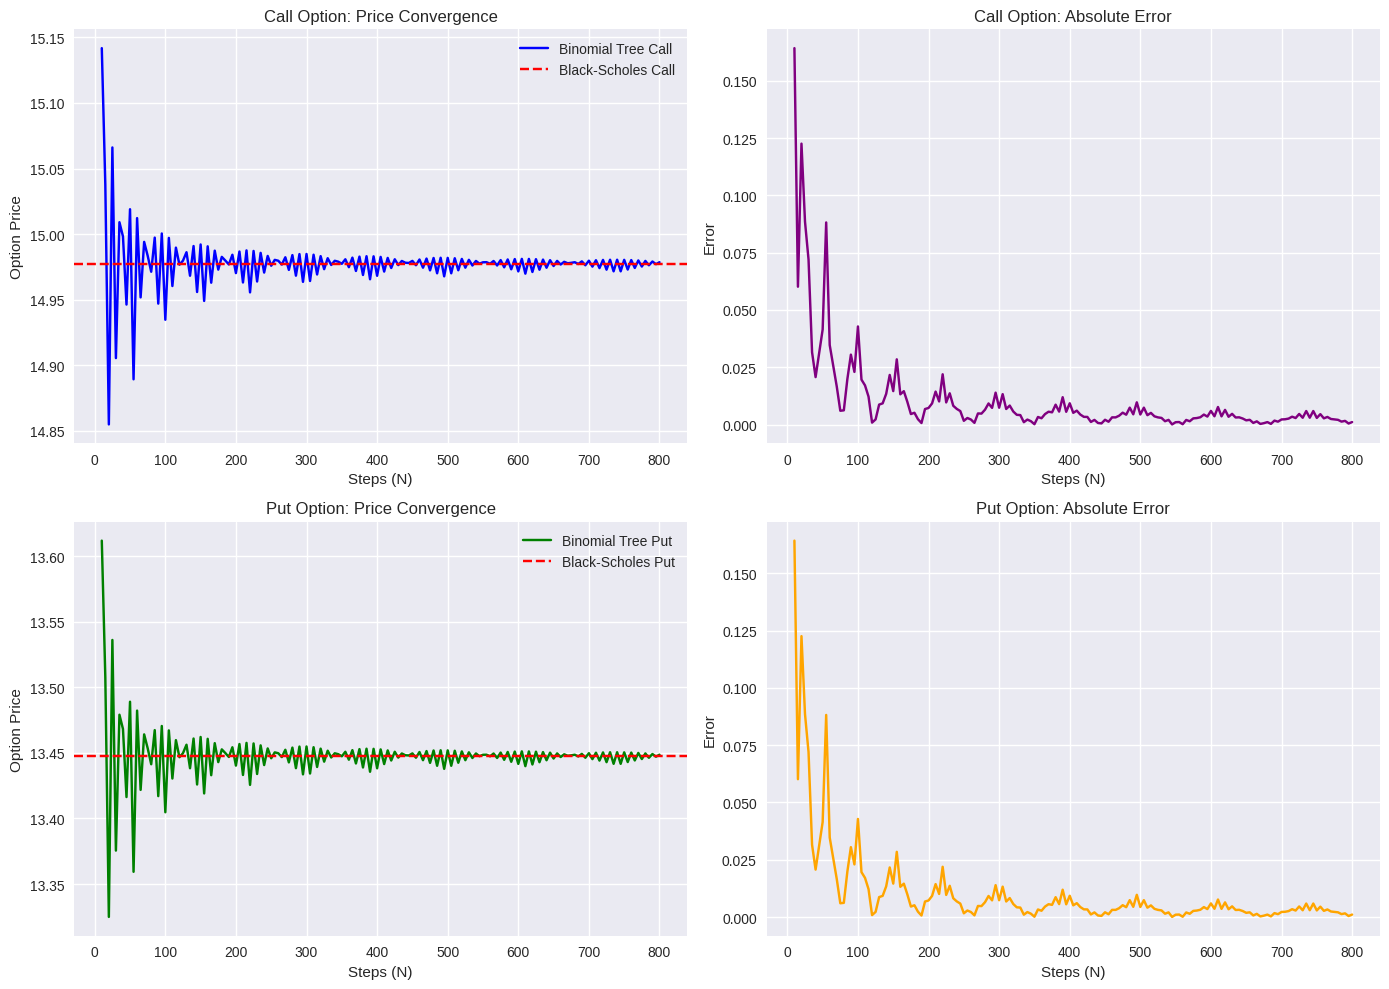

In [ ]:
# === Option Parameters ===
initial_stock_price = 200       # Spot price of the underlying asset (S)
strike_price = 215              # Strike price of the option (K)
time_to_maturity = 0.8          # Time to maturity in years (T)
risk_free_rate = 0.1            # Annual risk-free interest rate (r)
volatility = 0.2                 # Annual volatility of the asset (σ)

# === Binomial Tree Settings ===
step_range = list(range(10, 801, 5))  # Range of time steps (N) for binomial tree to observe convergence

# === Storage for Results ===
binomial_tree_call_prices = []  # Stores call option prices from the binomial tree model
binomial_tree_put_prices = []   # Stores put option prices from the binomial tree model

# === Compute Binomial Tree Prices for Call and Put Options ===
for number_of_steps in step_range:
    # Calculate call option price using binomial tree
    call_price = binomial_tree_option_pricing(
        initial_stock_price,
        strike_price,
        time_to_maturity,
        risk_free_rate,
        volatility,
        number_of_steps,
        'C'  # 'C' for call option
    )

    # Calculate put option price using binomial tree
    put_price = binomial_tree_option_pricing(
        initial_stock_price,
        strike_price,
        time_to_maturity,
        risk_free_rate,
        volatility,
        number_of_steps,
        'P'  # 'P' for put option
    )

    # Store the computed prices
    binomial_tree_call_prices.append(call_price)
    binomial_tree_put_prices.append(put_price)

# === Compute Benchmark Prices using Black-Scholes Formula ===
black_scholes_call = black_scholes_price(
    initial_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    volatility,
    'call'
)

black_scholes_put = black_scholes_price(
    initial_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    volatility,
    'put'
)

# === Create Subplots: 2 rows x 2 columns ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create 4 subplots for visualization

# === CALL OPTION VISUALIZATION ===

# (Top-left) Price convergence of Binomial Tree to Black-Scholes
axes[0, 0].plot(step_range, binomial_tree_call_prices, label='Binomial Tree Call', color='blue')
axes[0, 0].axhline(y=black_scholes_call, color='red', linestyle='--', label='Black-Scholes Call')
axes[0, 0].set_title("Call Option: Price Convergence")
axes[0, 0].set_xlabel("Steps (N)")
axes[0, 0].set_ylabel("Option Price")
axes[0, 0].legend()
axes[0, 0].grid(True)

# (Top-right) Absolute error between Binomial Tree and Black-Scholes call prices
call_absolute_errors = [abs(p - black_scholes_call) for p in binomial_tree_call_prices]
axes[0, 1].plot(step_range, call_absolute_errors, color='purple')
axes[0, 1].set_title("Call Option: Absolute Error")
axes[0, 1].set_xlabel("Steps (N)")
axes[0, 1].set_ylabel("Error")
axes[0, 1].grid(True)

# === PUT OPTION VISUALIZATION ===

# (Bottom-left) Price convergence of Binomial Tree to Black-Scholes
axes[1, 0].plot(step_range, binomial_tree_put_prices, label='Binomial Tree Put', color='green')
axes[1, 0].axhline(y=black_scholes_put, color='red', linestyle='--', label='Black-Scholes Put')
axes[1, 0].set_title("Put Option: Price Convergence")
axes[1, 0].set_xlabel("Steps (N)")
axes[1, 0].set_ylabel("Option Price")
axes[1, 0].legend()
axes[1, 0].grid(True)

# (Bottom-right) Absolute error between Binomial Tree and Black-Scholes put prices
put_absolute_errors = [abs(p - black_scholes_put) for p in binomial_tree_put_prices]
axes[1, 1].plot(step_range, put_absolute_errors, color='orange')
axes[1, 1].set_title("Put Option: Absolute Error")
axes[1, 1].set_xlabel("Steps (N)")
axes[1, 1].set_ylabel("Error")
axes[1, 1].grid(True)

# === Finalize Layout and Show Plot ===
plt.tight_layout()
plt.show()


# **model sensitivity to key parameters:**

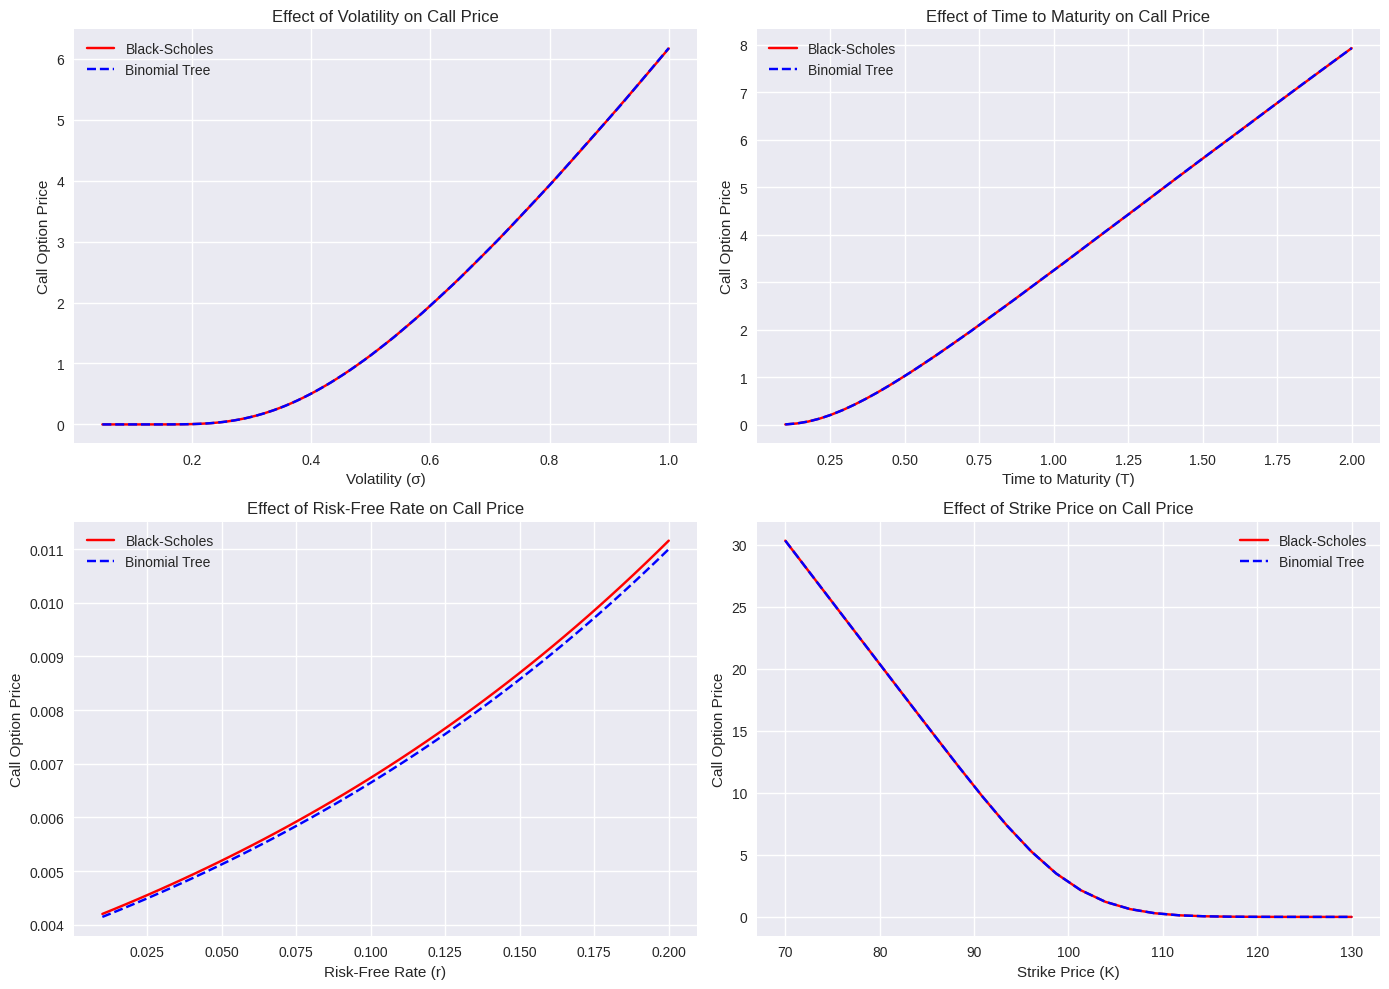

In [ ]:
# === Fixed Option Parameters ===
S = 100       # Current stock price (S)
K = 120       # Strike price (K)
T = 0.1       # Time to maturity in years (T)
r = 0.05      # Risk-free interest rate (r)
sigma = 0.2   # Volatility of the underlying asset (σ)
steps = 500   # Number of steps in the binomial tree (N)

# === Parameter Ranges for Sensitivity Analysis ===
vol_range = np.linspace(0.05, 1, 100)      # Range of volatilities to test
T_range = np.linspace(0.1, 2.0, 50)        # Range of maturities
r_range = np.linspace(0.01, 0.2, 50)       # Range of risk-free rates
K_range = np.linspace(70, 130, 24)         # Range of strike prices

# === Calculate Black-Scholes Prices for Varying Parameters ===
bs_vol = [black_scholes_price(S, K, T, r, v, 'call') for v in vol_range]
bs_T = [black_scholes_price(S, K, t, r, sigma, 'call') for t in T_range]
bs_r = [black_scholes_price(S, K, T, rate, sigma, 'call') for rate in r_range]
bs_K = [black_scholes_price(S, k, T, r, sigma, 'call') for k in K_range]

# === Calculate Binomial Tree Prices for Same Parameters ===
bt_vol = [binomial_tree_option_pricing(S, K, T, r, v, steps, 'C') for v in vol_range]
bt_T = [binomial_tree_option_pricing(S, K, t, r, sigma, steps, 'C') for t in T_range]
bt_r = [binomial_tree_option_pricing(S, K, T, rate, sigma, steps, 'C') for rate in r_range]
bt_K = [binomial_tree_option_pricing(S, k, T, r, sigma, steps, 'C') for k in K_range]

# === Plotting Comparison ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Volatility Sensitivity
axes[0, 0].plot(vol_range, bs_vol, label='Black-Scholes', color='red')
axes[0, 0].plot(vol_range, bt_vol, label='Binomial Tree', color='blue', linestyle='--')
axes[0, 0].set_title('Effect of Volatility on Call Price')
axes[0, 0].set_xlabel('Volatility (σ)')
axes[0, 0].set_ylabel('Call Option Price')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Maturity Sensitivity
axes[0, 1].plot(T_range, bs_T, label='Black-Scholes', color='red')
axes[0, 1].plot(T_range, bt_T, label='Binomial Tree', color='blue', linestyle='--')
axes[0, 1].set_title('Effect of Time to Maturity on Call Price')
axes[0, 1].set_xlabel('Time to Maturity (T)')
axes[0, 1].set_ylabel('Call Option Price')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Risk-Free Rate Sensitivity
axes[1, 0].plot(r_range, bs_r, label='Black-Scholes', color='red')
axes[1, 0].plot(r_range, bt_r, label='Binomial Tree', color='blue', linestyle='--')
axes[1, 0].set_title('Effect of Risk-Free Rate on Call Price')
axes[1, 0].set_xlabel('Risk-Free Rate (r)')
axes[1, 0].set_ylabel('Call Option Price')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Strike Price Sensitivity
axes[1, 1].plot(K_range, bs_K, label='Black-Scholes', color='red')
axes[1, 1].plot(K_range, bt_K, label='Binomial Tree', color='blue', linestyle='--')
axes[1, 1].set_title('Effect of Strike Price on Call Price')
axes[1, 1].set_xlabel('Strike Price (K)')
axes[1, 1].set_ylabel('Call Option Price')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


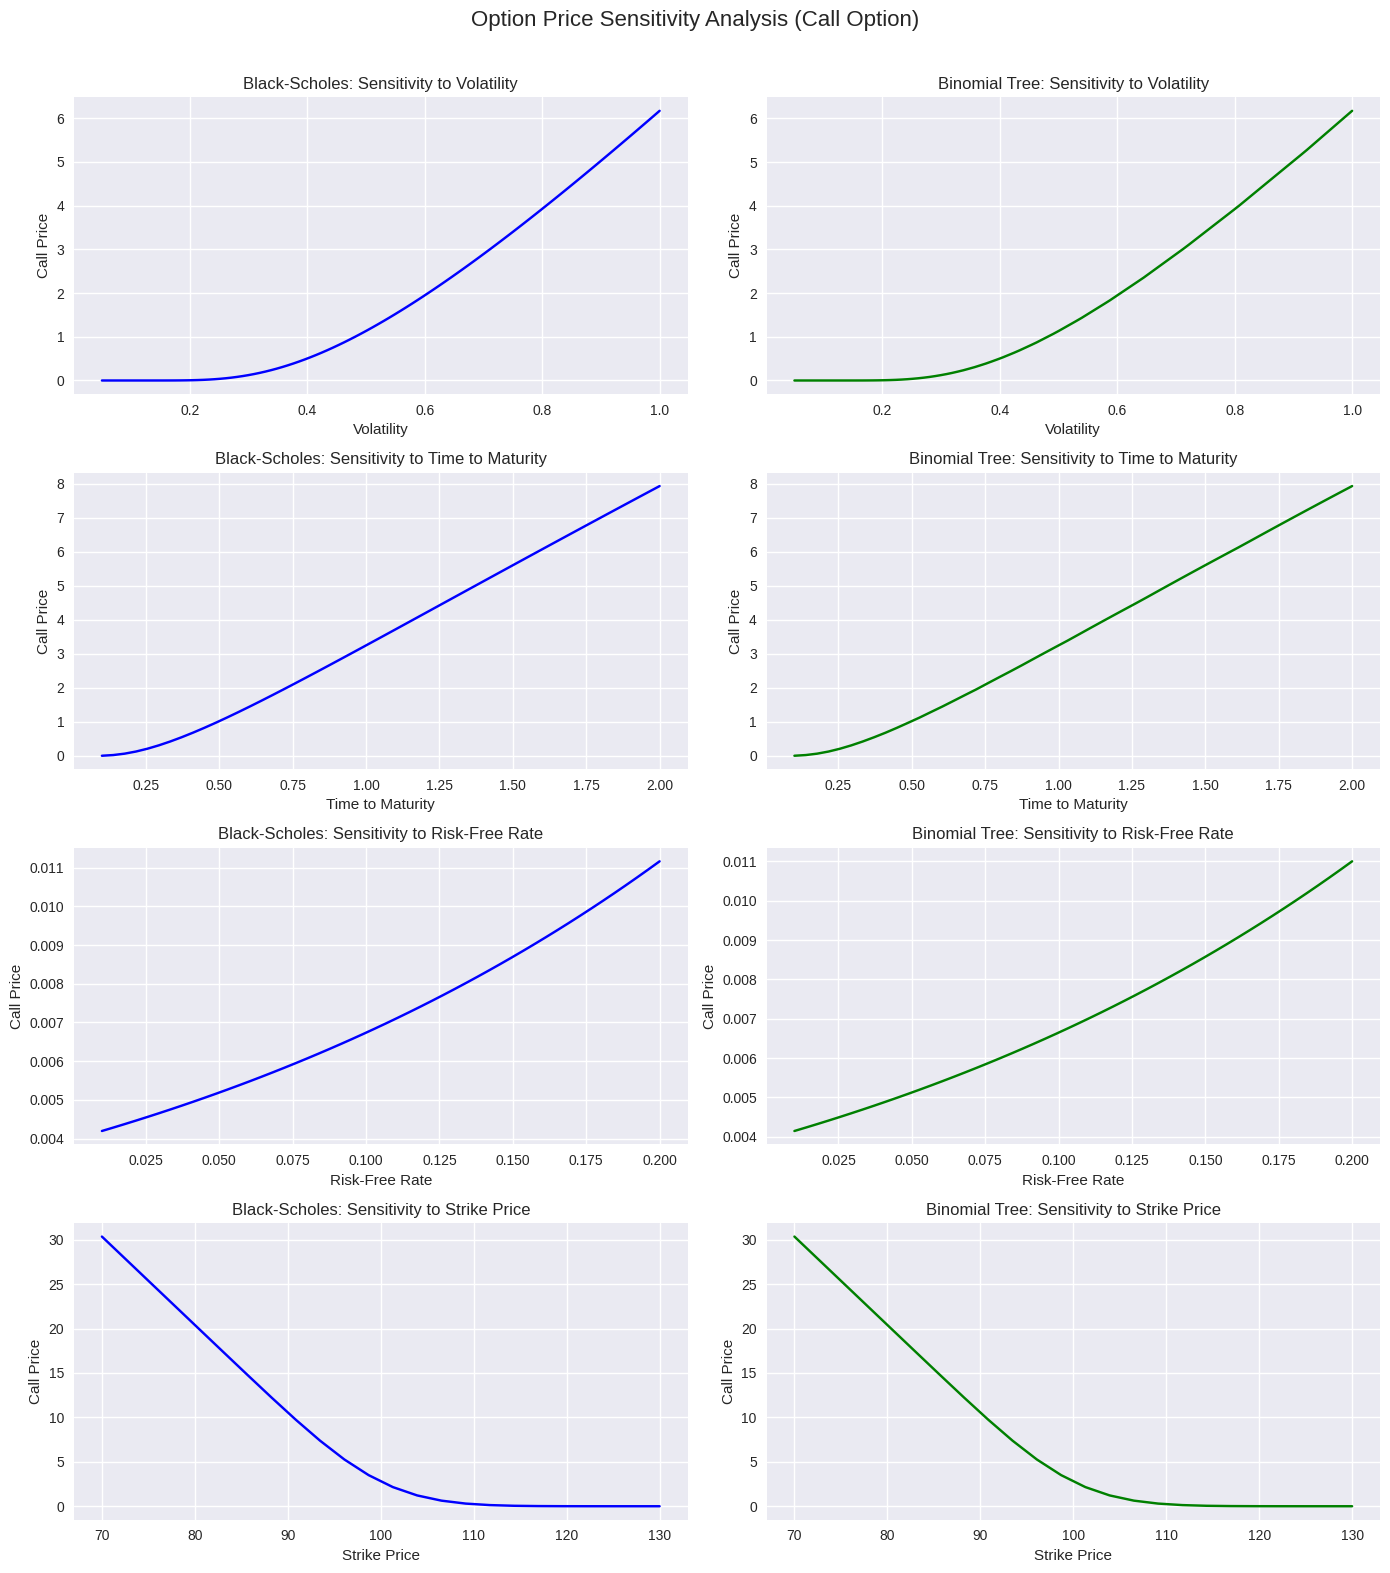

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle("Option Price Sensitivity Analysis (Call Option)", fontsize=16)

# Volatility
axes[0, 0].plot(vol_range, bs_vol, color='blue')
axes[0, 0].set_title("Black-Scholes: Sensitivity to Volatility")
axes[0, 0].set_xlabel("Volatility")
axes[0, 0].set_ylabel("Call Price")
axes[0, 0].grid(True)

axes[0, 1].plot(vol_range, bt_vol, color='green')
axes[0, 1].set_title("Binomial Tree: Sensitivity to Volatility")
axes[0, 1].set_xlabel("Volatility")
axes[0, 1].set_ylabel("Call Price")
axes[0, 1].grid(True)

# Time to maturity
axes[1, 0].plot(T_range, bs_T, color='blue')
axes[1, 0].set_title("Black-Scholes: Sensitivity to Time to Maturity")
axes[1, 0].set_xlabel("Time to Maturity")
axes[1, 0].set_ylabel("Call Price")
axes[1, 0].grid(True)

axes[1, 1].plot(T_range, bt_T, color='green')
axes[1, 1].set_title("Binomial Tree: Sensitivity to Time to Maturity")
axes[1, 1].set_xlabel("Time to Maturity")
axes[1, 1].set_ylabel("Call Price")
axes[1, 1].grid(True)

# Risk-free rate
axes[2, 0].plot(r_range, bs_r, color='blue')
axes[2, 0].set_title("Black-Scholes: Sensitivity to Risk-Free Rate")
axes[2, 0].set_xlabel("Risk-Free Rate")
axes[2, 0].set_ylabel("Call Price")
axes[2, 0].grid(True)

axes[2, 1].plot(r_range, bt_r, color='green')
axes[2, 1].set_title("Binomial Tree: Sensitivity to Risk-Free Rate")
axes[2, 1].set_xlabel("Risk-Free Rate")
axes[2, 1].set_ylabel("Call Price")
axes[2, 1].grid(True)

# Strike price
axes[3, 0].plot(K_range, bs_K, color='blue')
axes[3, 0].set_title("Black-Scholes: Sensitivity to Strike Price")
axes[3, 0].set_xlabel("Strike Price")
axes[3, 0].set_ylabel("Call Price")
axes[3, 0].grid(True)

axes[3, 1].plot(K_range, bt_K, color='green')
axes[3, 1].set_title("Binomial Tree: Sensitivity to Strike Price")
axes[3, 1].set_xlabel("Strike Price")
axes[3, 1].set_ylabel("Call Price")
axes[3, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# **comparison of models’ output to actual market prices.**

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf

In [ ]:
ticker = yf.Ticker("AAPL")
expiration_dates = ticker.options
print(expiration_dates)  # choose one expiration date

('2025-06-20', '2025-06-27', '2025-07-03', '2025-07-11', '2025-07-18', '2025-07-25', '2025-08-01', '2025-08-15', '2025-09-19', '2025-10-17', '2025-11-21', '2025-12-19', '2026-01-16', '2026-02-20', '2026-03-20', '2026-06-18', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')


In [ ]:
expiry = '2025-07-03'
option_chain = ticker.option_chain(expiry)
calls = option_chain.calls
puts = option_chain.puts
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250703C00140000,2025-06-11 19:36:11+00:00,140.0,59.42,0.0,0.0,0.0,0.0,2.0,1916,0.00001,True,REGULAR,USD
1,AAPL250703C00150000,2025-05-28 15:38:18+00:00,150.0,52.25,0.0,0.0,0.0,0.0,4.0,4,0.00001,True,REGULAR,USD
2,AAPL250703C00155000,2025-06-09 17:46:25+00:00,155.0,47.50,0.0,0.0,0.0,0.0,1.0,2,0.00001,True,REGULAR,USD
3,AAPL250703C00160000,2025-06-12 14:11:56+00:00,160.0,38.45,0.0,0.0,0.0,0.0,NaN,1,0.00001,True,REGULAR,USD
4,AAPL250703C00165000,2025-06-12 14:10:24+00:00,165.0,34.12,0.0,0.0,0.0,0.0,1.0,4,0.00001,True,REGULAR,USD


In [ ]:
calls[['strike', 'lastPrice', 'impliedVolatility','lastTradeDate']]

,strike,lastPrice,impliedVolatility,lastTradeDate
0,140.0,59.42,0.000010,2025-06-11 19:36:11+00:00
1,150.0,52.25,0.000010,2025-05-28 15:38:18+00:00
2,155.0,47.50,0.000010,2025-06-09 17:46:25+00:00
3,160.0,38.45,0.000010,2025-06-12 14:11:56+00:00
4,165.0,34.12,0.000010,2025-06-12 14:10:24+00:00
5,170.0,29.38,0.000010,2025-06-12 19:52:52+00:00
6,175.0,25.13,0.000010,2025-06-13 13:30:22+00:00
7,180.0,17.30,0.000010,2025-06-13 19:47:53+00:00
8,185.0,13.24,0.000010,2025-06-13 19:51:20+00:00
9,190.0,9.31,0.000010,2025-06-13 19:59:37+00:00


Comparison of Model-Based Option Pricing with Market Prices

In [ ]:
# === Get the current stock price from ticker data ===
# Retrieves the most recent closing price from the ticker's historical data
current_stock_price = ticker.history(period="1d")['Close'].iloc[-1]
print(f"Current Stock Price: ${current_stock_price:.2f}")

# === Select a specific option row (e.g., strike = 200) ===
# Filters the options DataFrame to find the row where strike price = 200
# Then extracts the strike and calculates time to maturity in years
selected_option_row = calls[calls['strike'] == 200].iloc[0]
strike_price = selected_option_row['strike']
expiry_date = pd.to_datetime(expiry)
today = pd.Timestamp.today()
time_to_maturity = (expiry_date - today).days / 365  # Time to maturity in years

# === Market data for the selected option ===
# Get the market's last traded price and implied volatility for the option
market_option_price = selected_option_row['lastPrice']
implied_volatility = selected_option_row['impliedVolatility']  # Already in decimal form

# === Model-based theoretical prices ===
# Compute theoretical option prices using both Black-Scholes and Binomial Tree models
black_scholes_model_price = black_scholes_price(
    current_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    0.25,
    'call'
)

binomial_tree_model_price = binomial_tree_option_pricing(
    current_stock_price,
    strike_price,
    time_to_maturity,
    risk_free_rate,
    0.25,
    4,  # Number of steps in the binomial tree
    'C'
)

# === Print the results ===
# Output all computed and market values
print(f"Market Price: ${market_option_price:.2f}")
print(f"Black-Scholes Price: ${black_scholes_model_price:.2f}")
print(f"Binomial Tree Price: ${binomial_tree_model_price:.2f}")

# === Differences Between Models and Market ===
# Calculate and print absolute and percentage differences for each model
bs_abs_diff = abs(black_scholes_model_price - market_option_price)
bs_pct_diff = (bs_abs_diff / market_option_price) * 100

bt_abs_diff = abs(binomial_tree_model_price - market_option_price)
bt_pct_diff = (bt_abs_diff / market_option_price) * 100

print(f"\nBlack-Scholes Absolute Difference: ${bs_abs_diff:.2f}")
print(f"Black-Scholes Percentage Difference: {bs_pct_diff:.2f}%")

print(f"Binomial Tree Absolute Difference: ${bt_abs_diff:.2f}")
print(f"Binomial Tree Percentage Difference: {bt_pct_diff:.2f}%")


Current Stock Price: $197.34
Market Price: $3.50
Black-Scholes Price: $3.31
Binomial Tree Price: $3.42

Black-Scholes Absolute Difference: $0.19
Black-Scholes Percentage Difference: 5.50%
Binomial Tree Absolute Difference: $0.08
Binomial Tree Percentage Difference: 2.17%


In [ ]:
# Ask user to input ticker and expiry
ticker_symbol = input("Enter the stock symbol (e.g., AAPL, SPY): ").upper()
tickerr = yf.Ticker(ticker_symbol)

# Show available expiration dates
print("\nAvailable Expiration Dates:")
for i, date in enumerate(tickerr.options):
    print(f"{i+1}. {date}")

# Let user pick a date by index or enter manually
user_date = input("\nEnter an expiry date from the list above (format: YYYY-MM-DD): ")

# Validate input
if user_date not in tickerr.options:
    print("❌ Invalid expiry date. Please pick a date from the list above.")
else:
    # Fetch option chain
    option_chainn = tickerr.option_chain(user_date)
    callss = option_chainn.calls
    putss = option_chainn.puts

    # Display first few rows of data
    print("\n📈 Sample Call Options:")
    print(callss[['strike', 'lastPrice', 'impliedVolatility']].head())

    print("\n📉 Sample Put Options:")
    print(putss[['strike', 'lastPrice', 'impliedVolatility']].head())


Enter the stock symbol (e.g., AAPL, SPY): aapl

Available Expiration Dates:
1. 2025-06-20
2. 2025-06-27
3. 2025-07-03
4. 2025-07-11
5. 2025-07-18
6. 2025-07-25
7. 2025-08-01
8. 2025-08-15
9. 2025-09-19
10. 2025-10-17
11. 2025-11-21
12. 2025-12-19
13. 2026-01-16
14. 2026-02-20
15. 2026-03-20
16. 2026-06-18
17. 2026-09-18
18. 2026-12-18
19. 2027-01-15
20. 2027-06-17
21. 2027-12-17

Enter an expiry date from the list above (format: YYYY-MM-DD): 2025-07-18

📈 Sample Call Options:
   strike  lastPrice  impliedVolatility
0    90.0     115.24            0.00001
1    95.0     107.37            0.00001
2   100.0     104.94            0.00001
3   105.0      97.38            0.00001
4   110.0      95.46            0.00001

📉 Sample Put Options:
   strike  lastPrice  impliedVolatility
0    90.0       0.01           0.500005
1    95.0       0.02           0.500005
2   100.0       0.02           0.500005
3   105.0       0.02           0.500005
4   110.0       0.02           0.500005


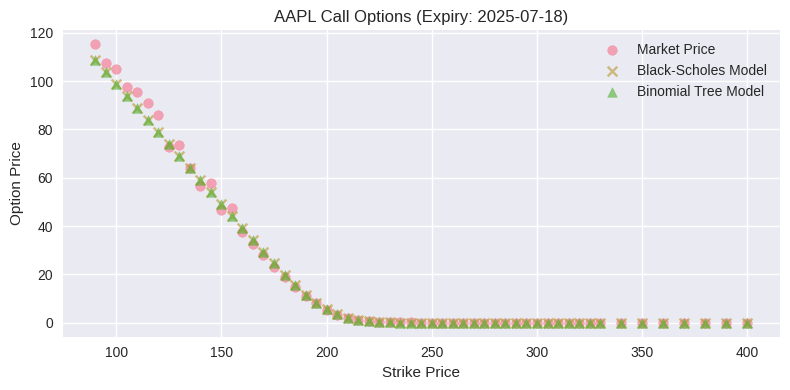

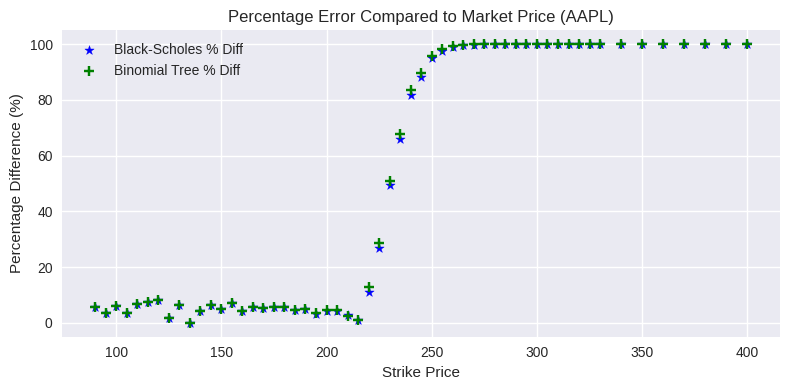

In [ ]:
# === Model Parameters ===
# Get current stock price (last closing price)
current_stock_price = tickerr.history(period="1d")['Close'].iloc[0]

# Risk-free interest rate (annualized)
risk_free_rate = 0.10

# Calculate time to expiry in years from user-provided expiry date
time_to_expiry = (pd.to_datetime(user_date) - pd.Timestamp.today()).days / 365

# Drop rows with missing implied volatility or market price
callss = callss.dropna(subset=['impliedVolatility', 'lastPrice'])

# === Initialize result containers ===
strike_prices = []           # Strike prices of options
market_prices = []           # Market prices of options
bs_model_prices = []         # Black-Scholes model prices
binomial_model_prices = []   # Binomial Tree model prices

# === Loop through each call option and compute model prices ===
for _, row in callss.iterrows():
    strike_price = row['strike']
    market_price = row['lastPrice']
    implied_volatility = row['impliedVolatility']

    try:
        # Compute Black-Scholes price
        bs_price = black_scholes_price(
            current_stock_price,
            strike_price,
            time_to_expiry,
            risk_free_rate,
            0.25,
            'call'
        )

        # Compute Binomial Tree price
        bt_price = binomial_tree_option_pricing(
            initial_stock_price=current_stock_price,
            strike_price=strike_price,
            time_to_maturity=time_to_expiry,
            risk_free_rate=risk_free_rate,
            volatility=0.25,
            number_of_steps=50,
            option_type='C'
        )
    except Exception:
        continue  # Skip the row if pricing fails

    # Append values to results
    strike_prices.append(strike_price)
    market_prices.append(market_price)
    bs_model_prices.append(bs_price)
    binomial_model_prices.append(bt_price)

# === Plot 1: Comparison of Market and Model Prices ===
plt.figure(figsize=(8, 4))
plt.scatter(strike_prices, market_prices, label='Market Price', alpha=0.6, marker='o')
plt.scatter(strike_prices, bs_model_prices, label='Black-Scholes Model', alpha=0.6, marker='x')
plt.scatter(strike_prices, binomial_model_prices, label='Binomial Tree Model', alpha=0.6, marker='^')
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title(f"{ticker_symbol.upper()} Call Options (Expiry: {user_date})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Percentage Difference from Market ===
# Compute % differences
bs_percentage_diff = [100 * abs(bs - mkt) / mkt for bs, mkt in zip(bs_model_prices, market_prices)]
bt_percentage_diff = [100 * abs(bt - mkt) / mkt for bt, mkt in zip(binomial_model_prices, market_prices)]

plt.figure(figsize=(8, 4))
plt.scatter(strike_prices, bs_percentage_diff, label='Black-Scholes % Diff', color='blue', marker='*')
plt.scatter(strike_prices, bt_percentage_diff, label='Binomial Tree % Diff', color='green', marker ='+')
plt.xlabel("Strike Price")
plt.ylabel("Percentage Difference (%)")
plt.title(f"Percentage Error Compared to Market Price ({ticker_symbol.upper()})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Which model may be preferable over the other.**

### Conclusion: When is Each Model Preferable?

Based on our experiments, the following conclusions can be drawn:

- **Black-Scholes Model**:
  - Suitable for pricing **European options** with constant volatility and interest rates.
  - Offers **instant computation** using a closed-form solution.
  - Best for **short-to-medium term options** and fast pricing.

- **Binomial Tree Model**:
  - Suitable for both **European and American options** (with early exercise capability).
  - Allows modeling of **changing market conditions** and discrete dividends.
  - More **flexible** but requires **more computational resources**.

**Therefore**, if your goal is fast and accurate pricing under typical market assumptions, **Black-Scholes** is preferred.  
If you need to model non-standard features or American options, choose **Binomial Tree**.


# **Performance Comparison Report**

## 1. Pricing Accuracy

- **Goal**: Compare Binomial Tree prices with Black-Scholes prices.
- **Result**:
  - As the number of steps increases (e.g., N = 500 to 1000), the Binomial model price closely matches the Black-Scholes price.
  - The error becomes negligible for European options.
  
 **Conclusion**: Binomial Tree is accurate when step size is sufficiently small.

---

## 2. Computational Efficiency

- **Method**: Timed both models using Python's `time` module.
- **Observation**:
  - Black-Scholes: instant (closed-form formula).
  - Binomial Tree: slower, time increases linearly with steps.

 **Conclusion**:  
Use **Black-Scholes** for fast, analytical pricing.  
Use **Binomial Tree** for flexibility (e.g., dividends, American options), despite longer runtimes.

---

## 3. Error Convergence

- **Analysis**: Absolute error between Binomial and Black-Scholes prices decreases as the number of steps increases.
- **Visual Proof**: Error plots show convergence to < 0.01 for both call and put options as `N → 1000`.

**Conclusion**: Binomial Tree reliably converges to Black-Scholes values with high step counts.

---

## 4. Visual Comparisons

###  Price Convergence
- Binomial prices plotted vs. number of steps
- Red dashed line shows constant Black-Scholes value
- Shows visual convergence of Binomial Tree

###  Sensitivity to Key Variables
Tested sensitivity to:
- Volatility
- Time to maturity
- Risk-free interest rate
- Strike price

Both **Black-Scholes** and **Binomial Tree** outputs compared in side-by-side plots.

---

## 5. Deviations from Market Prices (Optional)

- You can add real market option prices (e.g., via `yfinance`) and compare them to your model outputs.
- This can highlight **implied volatility** and **real-world deviations** due to market inefficiencies.

---

##  Final Summary

| Feature            | Binomial Tree         | Black-Scholes        |
|--------------------|-----------------------|-----------------------|
| Time Model         | Discrete              | Continuous            |
| Accuracy           | Approximates BS       | Exact (under assumptions) |
| Speed              | Slower                | Very Fast             |
| Flexibility        | High (American, dividends) | Limited (European only) |
| Convergence        | Yes, with steps       | Not needed (closed-form) |

Both models assume:
- No arbitrage
- Constant volatility
- Frictionless markets

 Use **Black-Scholes** when speed and elegance matter.  
 Use **Binomial Tree** when flexibility and step-by-step modeling are needed.


Timing for Computational Efficiency

In [ ]:
import time

# Parameters
S = 100
K = 110
T = 0.15
r = 0.05
sigma = 0.2
steps = 1000

# --- Timing Black-Scholes ---
start_bs = time.time()
bs_price = black_scholes_price(S, K, T, r, sigma,'call')
end_bs = time.time()
bs_time = end_bs - start_bs

# --- Timing Binomial Tree ---
start_bt = time.time()
bt_price = binomial_tree_option_pricing(S, K, T, r, sigma, steps, 'C')
end_bt = time.time()
bt_time = end_bt - start_bt

# --- Print results ---
print(f"Black-Scholes Price: {bs_price:.4f}, Time: {bs_time*1e3:.4f} ms")
print(f"Binomial Tree Price: {bt_price:.4f}, Time: {bt_time:.4f} s (N = {steps})")


Black-Scholes Price: 0.5192, Time: 1.5416 ms
Binomial Tree Price: 0.5194, Time: 0.0420 s (N = 1000)
